# Import

In [1]:
# generic
import matplotlib.pyplot as plt
import numpy as np

# custom
import obj
import processing

# Toggles

In [2]:
is_kernel = False
is_conv = False
is_fft = False
is_nlm = True

# Setup

Image size:  (128, 128)


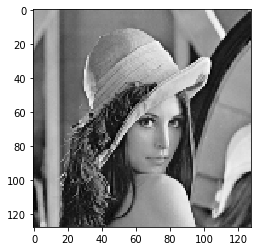

In [3]:
test_path = './test.png'
size = 128
img = obj.Image(test_path, size)
print("Image size: ", img.data.shape)
plt.imshow(img.data, cmap ='gray')

# Kernel Test

In [4]:
if is_kernel:
    # create ad populate kernel
    kernel = obj.Kernel(3)
    kernel.generateFilter(1)

    print("Generated Filter")
    print(kernel.data)
    print("Sum:", np.sum(kernel.data))
    print('\n')
    print("Pretty Generated Filter")
    print(kernel.data / np.min(kernel.data))
    print("Sum:", np.sum(kernel.data))

# Convolution Test

In [5]:
if is_conv:   
    img_in = obj.Image(test_path, size)
    img_out = obj.Image(test_path, size)
    img_out.clear()

    processing.convolve(img_in, img_out, kernel)

    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(121), plt.imshow(img_in.data, cmap='gray')
    plt.title("Fig 1: Original Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_out.data,  cmap='gray')
    plt.title("Fig 2: Smoothed Image"), plt.xticks([]), plt.yticks([])
    plt.show()

# Fourier Test

In [6]:
if is_fft:
    cimg_in = img = obj.CImage(test_path, size // 4)
    cimg_out = img = obj.CImage(test_path, size // 4)
    img_rev = img = obj.Image(test_path, size // 4)
    img_rev.clear()
    cimg_out.clear()

    processing.fft(cimg_in, cimg_out)
    processing.ifft(cimg_out, img_rev)

    plt.rcParams["figure.figsize"] = (15,15)
    plt.subplot(121), plt.imshow(cimg_in.re, cmap='gray')
    plt.title("Fig 1: Original Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img_rev.data,  cmap='gray')
    plt.title("Fig 2: Reverted Image"), plt.xticks([]), plt.yticks([])
    plt.show()

# Non-Local Means Test

In [7]:
def fuzz(image, ranges, p=0.15):
    rows, cols = image.shape
    for row in range(rows):
        for col in range(cols):
            if(np.random.uniform() < p):
                image[row][col] += np.random.randint(-ranges, ranges)

In [8]:
if is_nlm:
    img_gt = obj.Image(test_path, size // 2)
    img_in = obj.Image(test_path, size // 2)
    fuzz(img_in.data, 15, 0.9)
    img_out = obj.Image(test_path, size //2)
    img_out.clear()

    processing.nlm(img_in, img_out, 7, 3, 0.5)

    plt.rcParams["figure.figsize"] = (20,20)
    plt.subplot(131), plt.imshow(img_gt.data, cmap='gray')
    plt.title("Fig 2: Input Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(132), plt.imshow(img_in.data, cmap='gray')
    plt.title("Fig 2: Noise Image"), plt.xticks([]), plt.yticks([])
    plt.subplot(133), plt.imshow(img_out.data,  cmap='gray')
    plt.title("Fig 3: Smoothed Image"), plt.xticks([]), plt.yticks([])
    plt.show()